In [73]:
import tensorflow as tf
import os
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import cv2
import imghdr
data_dir = '/content/drive/MyDrive/Sclera_dataset/jnjimages'
image_exts = ['jpeg','jpg', 'bmp', 'png']

Applying Trained Eyes Segmentation Model on Dataset

In [26]:
# !pip install segmentation-models-pytorch
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

In [4]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [5]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name='timm-efficientnet-b0',
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self,images,masks=None):
    logits=self.arc(images)

    if masks!= None:
      loss1=DiceLoss(mode='binary')(logits,masks)
      loss2=nn.BCEWithLogitsLoss()(logits,masks)

      return logits,loss1+loss2

    return logits

In [6]:
#import model
model=SegmentationModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Sclera_dataset/best_model_timm-efficientnet-b0.pt'))


Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 99.3MB/s]


<All keys matched successfully>

In [7]:
model.eval()

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_names = os.listdir(image_folder)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_names[idx])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.image_names[idx]

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])



In [13]:
# Load test dataset
test_dataset = CustomDataset(image_folder='/content/drive/MyDrive/Sclera_dataset/jnjimages/Jaundiced Eyes', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
output_folder = '/content/drive/MyDrive/Sclera_dataset/new_seg/seg_jaun_eye'

In [ ]:
# Load test dataset
test_dataset = CustomDataset(image_folder='/content/drive/MyDrive/Sclera_dataset/jnjimages/Eyes', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
output_folder = '/content/drive/MyDrive/Sclera_dataset/new_seg/seg_eye'

In [14]:
# # Helper function to overlay mask on image
def overlay_mask(image, mask, alpha=1):
    """Overlay mask on image."""
    image = image.numpy().transpose(1, 2, 0)
    mask = mask.numpy().transpose(1, 2, 0)
    overlay = image*mask
    overlay=(1-alpha)*image+alpha*overlay
    return overlay


In [15]:
# Apply model to test dataset
with torch.no_grad():
    for images, image_names in test_loader:
        outputs = model(images)
        pred_mask=torch.sigmoid(outputs)
        pred_mask=(pred_mask>0.5)*1.0
        # _, predicted = torch.max(outputs, 1)

        for img_name, img, pred in zip(image_names,images, pred_mask):
            # Save the segmented image
            segmented_img = overlay_mask(img, pred)
            segmented_img_pil = Image.fromarray((segmented_img * 128).astype(np.uint8))
            segmented_img_pil.save(os.path.join(output_folder, img_name))
            print(f"Image: {img_name}, Predicted class: {pred_mask}")



Streaming output truncated to the last 5000 lines.
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 

Classification of jaundice and not jaundice

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Sclera_dataset/new_seg')

In [5]:
data_dir

PosixPath('/content/drive/MyDrive/Sclera_dataset/new_seg')

/content/drive/MyDrive/Sclera_dataset/new_seg/seg_eye/subtle-winged-cats-eye.jpg


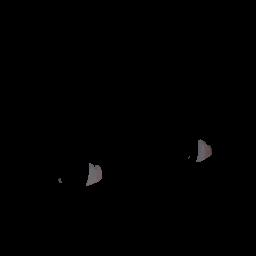

In [6]:
eyes = list(data_dir.glob('seg_eye/*'))
print(eyes[1])
PIL.Image.open(str(eyes[1]))

In [7]:
img_height,img_width=256,256
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 464 files belonging to 2 classes.
Using 372 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 464 files belonging to 2 classes.
Using 92 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['seg_eye', 'seg_jaun_eye']


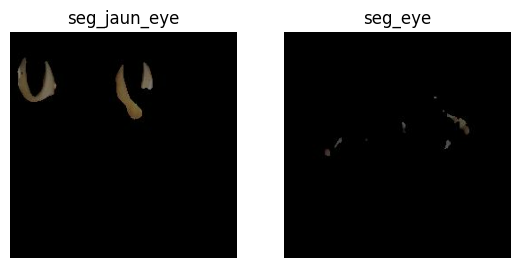

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# Data augmentation and normalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
])

In [12]:
import tensorflow as tf

resnet_model = tf.keras.Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256, 256, 3),
    weights='imagenet',
    pooling='avg'
)  # Using EfficientNetB0 as the pretrained model

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(tf.keras.layers.InputLayer(input_shape=(256, 256, 3)))
resnet_model.add(data_augmentation)
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.BatchNormalization())
resnet_model.add(tf.keras.layers.Dropout(0.5))
resnet_model.add(tf.keras.layers.Dense(64, activation='relu'))
resnet_model.add(tf.keras.layers.BatchNormalization())
resnet_model.add(tf.keras.layers.Dropout(0.5))
resnet_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                     

In [14]:
resnet_model.compile(optimizer=Adam(lr=0.005),loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
epochs=10
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
12/12 [==============================] - 131s 10s/step - loss: 0.8598 - accuracy: 0.6425 - val_loss: 0.3801 - val_accuracy: 0.8261
Epoch 2/10
12/12 [==============================] - 119s 10s/step - loss: 0.4522 - accuracy: 0.8468 - val_loss: 0.3298 - val_accuracy: 0.8804
Epoch 3/10
12/12 [==============================] - 119s 10s/step - loss: 0.3657 - accuracy: 0.8575 - val_loss: 0.3668 - val_accuracy: 0.8696
Epoch 4/10
12/12 [==============================] - 115s 10s/step - loss: 0.3680 - accuracy: 0.8575 - val_loss: 0.3006 - val_accuracy: 0.8913
Epoch 5/10
12/12 [==============================] - 120s 10s/step - loss: 0.3824 - accuracy: 0.8548 - val_loss: 0.2366 - val_accuracy: 0.9239
Epoch 6/10
12/12 [==============================] - 118s 10s/step - loss: 0.3507 - accuracy: 0.8656 - val_loss: 0.2458 - val_accuracy: 0.9022
Epoch 7/10
12/12 [==============================] - 136s 11s/step - loss: 0.3041 - accuracy: 0.9005 - val_loss: 0.2444 - val_accuracy: 0.8913
Epoch 

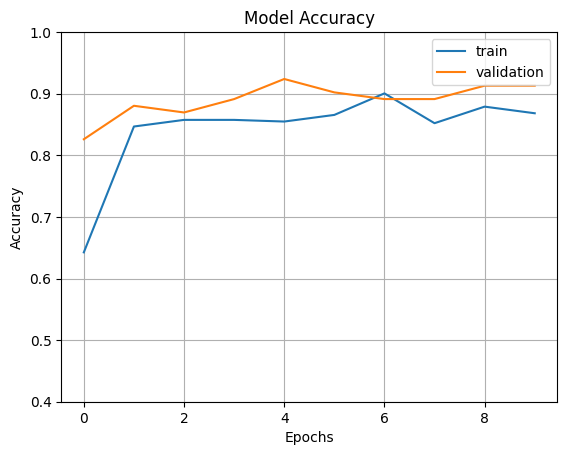

In [16]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

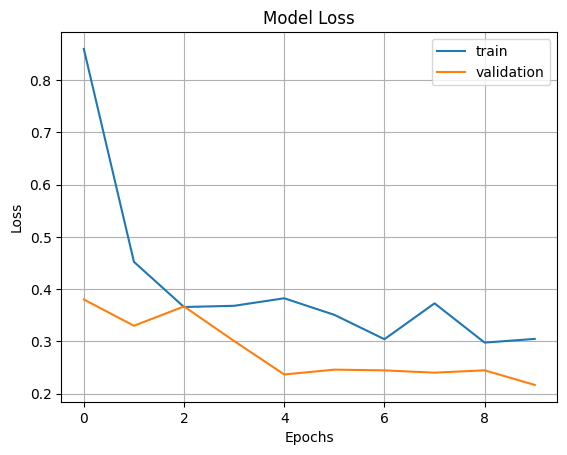

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
import cv2
image=cv2.imread(str(eyes[0]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)

(1, 256, 256, 3)


In [19]:
eyes = list(data_dir.glob('seg_jaun_eye/*'))

In [20]:
eyes[0]

PosixPath('/content/drive/MyDrive/Sclera_dataset/new_seg/seg_jaun_eye/Image_1.jpg')

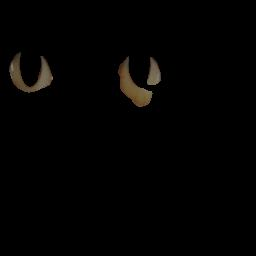

In [21]:
PIL.Image.open(str(eyes[11]))

In [22]:
image=cv2.imread(str(eyes[11]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
pred=resnet_model.predict(image)
print(pred)

(1, 256, 256, 3)
1/1 [==============================] - 2s 2s/step
[[0.84338087]]


In [23]:
output_class=class_names[int(pred[0][0] >= 0.5)]
print("The predicted class is", output_class)


The predicted class is seg_jaun_eye


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [25]:
# Make predictions on the validation set
val_predictions = resnet_model.predict(val_ds)
val_labels = np.concatenate([label for _, label in val_ds])

# Assuming binary classification, get the predicted labels
val_pred_labels = (val_predictions >= 0.5).astype(int).flatten()

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_pred_labels)
recall = recall_score(val_labels, val_pred_labels)
f1 = f1_score(val_labels, val_pred_labels)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Optional: Get a detailed classification report
report = classification_report(val_labels, val_pred_labels)
print(report)

3/3 [==============================] - 23s 7s/step
Precision: 0.39473684210526316
Recall: 0.375
F1 Score: 0.3846153846153846
              precision    recall  f1-score   support

           0       0.54      0.56      0.55        52
           1       0.39      0.38      0.38        40

    accuracy                           0.48        92
   macro avg       0.47      0.47      0.47        92
weighted avg       0.48      0.48      0.48        92



In [74]:
val_labels

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0], dtype=int32)

In [75]:
val_pred_labels

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0])